In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 6
import lsst.syseng.throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs(rootDir = '..')
detector_rootdir = defaultDirs['detector'].replace('/joint_minimum', '')

addLosses = True

hardware = {}
system = {}
m5 = {}
atmosphere = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
hardware['combo'], system['combo'] = st.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)
m5['combo'] = st.makeM5(hardware['combo'], system['combo'])

detectors = ['itl', 'e2v']
for det in detectors:
    defaultDirs['detector'] = os.path.join(detector_rootdir, det)
    hardware[det], system[det] = st.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)
    m5[det] = st.makeM5(hardware[det], system[det])

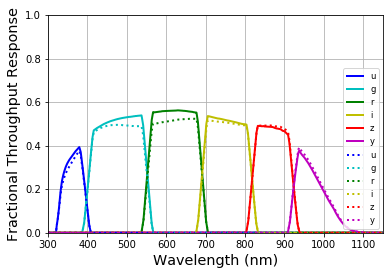

In [3]:
# Did we get different detectors?
st.plotBandpasses(hardware['e2v'], addlegend=False, newfig=False)
st.plotBandpasses(hardware['itl'], newfig=False, linestyle=':')

In [4]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g',
                'i':'y', 'z':'r', 'y':'m'}

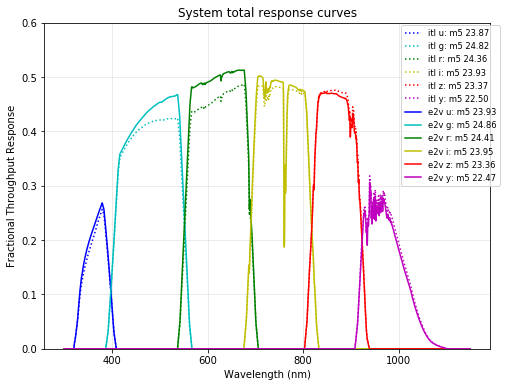

In [5]:
# Show what these look like (print m5 limits on throughput curves)
plt.figure(figsize=(8, 6))
for det in detectors:
    for f in filterlist:
        if det == 'itl':
            linestyle = ':'
        else:
            linestyle = '-'
        plt.plot(system[det][f].wavelen, system[det][f].sb, linestyle=linestyle, color=filtercolors[f],
                label='%s %s: m5 %.2f' %(det, f, m5[det].loc[f, 'm5']))
plt.legend(loc=(0.8, 0.5), fancybox=True, numpoints=1, fontsize='small')
plt.ylim(0, 0.6)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fractional Throughput Response')
plt.title('System total response curves')
plt.grid(True, alpha=0.3)

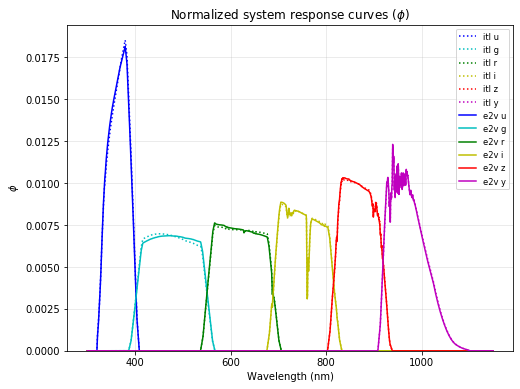

In [6]:
plt.figure(figsize=(8, 6))
for det in detectors:
    for f in filterlist:
        if det == 'itl':
            linestyle = ':'
        else:
            linestyle = '-'
        plt.plot(system[det][f].wavelen, system[det][f].phi, linestyle=linestyle, color=filtercolors[f], label='%s %s' %(det, f))
plt.legend(loc='upper right', fancybox=True, numpoints=1, fontsize='small')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\phi$')
plt.ylim(bottom=0)
plt.title('Normalized system response curves ($\phi$)')
plt.grid(True, alpha=0.3)

In [7]:
# Calculate color terms (magnitudes)
sedDir = '../seds'
seds = st.readPhotSeds(sedDir = sedDir)
redshifts = {}
redshifts['galaxies'] = np.array([0.5, 1.0], 'float')
redshifts['quasar'] = np.array([1.0, 1.5, 2.5], 'float')
redshifts['sn'] = np.array([0.3, 0.8, 1.2, 1.5], 'float')
redshifts['photoZ_outliers'] = np.array([0, 0.2, 1.0], 'float')
seds = st.makeRedshiftedSeds(seds, redshifts)
seds, system['combo'] = st.matchSedsBp(seds, system['combo'])

In [8]:
mags = {}
mags[1] = {}
mags[2] = {}
for det in detectors:
    mags[det] = st.calcNatMags(system[det], seds)
dmags = st.calcDeltaMags(mags['itl'], mags['e2v'], mmags=True, matchBlue=False)

gi = st.calcGiColors(mags['itl'])
ug = st.calcAnyColor(mags['itl'], 'u', 'g')

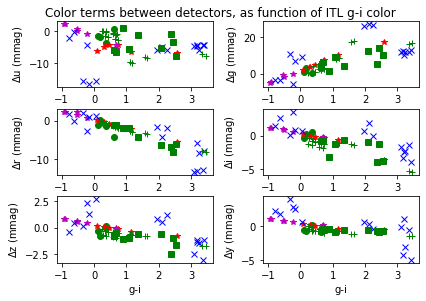

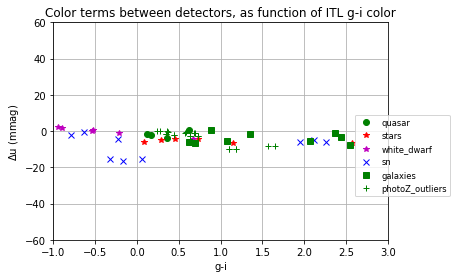

In [9]:
st.plotDmags(gi, dmags, titletext='Color terms between detectors, as function of ITL g-i color')
st.plotDmagsSingle(gi, dmags, titletext='Color terms between detectors, as function of ITL g-i color')
plt.ylim(-60, 60)
plt.xlim(-1, 3)
plt.grid()

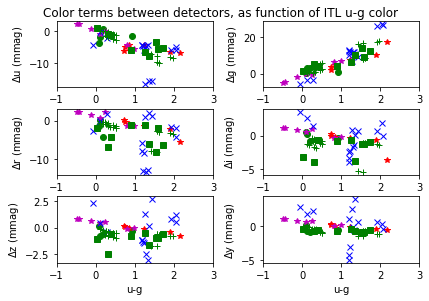

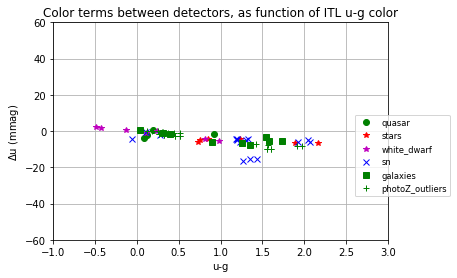

In [10]:
st.plotDmags(ug, dmags, colorname='u-g', xlim=[-1, 3],
            titletext='Color terms between detectors, as function of ITL u-g color')
st.plotDmagsSingle(ug, dmags, colorname='u-g',
                titletext='Color terms between detectors, as function of ITL u-g color')
plt.ylim(-60, 60)
plt.xlim(-1, 3)
plt.grid()